In [6]:
import pandas as pd
import numpy as np
import re
from pyecharts import Pie,Line,Bar,Geo, Map, WordCloud
import hashlib
import matplotlib.pyplot as plt
import matplotlib
import jieba
from collections import Counter

## 读取北京市积分落户公示名单

In [7]:
df = pd.read_excel("bjjflu20181015.xlsx", encoding = 'gbk' )

## 从中国统计年鉴读取各省（不含港澳台）的人口数据

In [8]:
with open('中国统计年鉴_分省年度人口数据.csv', encoding = 'gbk') as fr:
    province_population = dict()
    for i,line in enumerate(fr.readlines()):
        if i > 3 and i < 35:
            lineArr = line.strip().split(',')
            province = lineArr[0]
            population = int(lineArr[1])
            province_population[province] = population
                        
## 增加港澳台地区人口数据，单位：万；来源：百度百科
### 香港 ： 741
### 澳门 ： 66
### 台湾 ： 2349
province_population["香港特别行政区"] = 741
province_population["澳门特别行政区"] = 66
province_population["台湾省"] = 2349

city_df = pd.DataFrame({"省份": list(province_population.keys()),
                       "省份人口" : list(province_population.values())})

## 解码完整的身份证号码

In [29]:
### 涉及隐私，此部分跳过


## 根据身份证号码计算出出生年份、2019年年龄、性别信息、行政代码


In [10]:
def cal_age(date):
    year =  int(str(date)[:4])
    age = 2019 - year
    return age

def marry_area_id(Id):
    return Id[:6]

def marry_gender(Id):
    try:
        digit = int(Id[-2])
        if digit % 2 == 0:
            return '女'
        if digit % 2 == 1:
            return '男'
    except:
        return "未知"
    
    
df['行政代码'] = df['idCard'].apply(marry_area_id)
df['年龄'] = df['出生年月'].apply(cal_age)
df['性别'] = df['完整身份证号码'].apply(marry_gender)

## 匹配户籍省份信息

In [11]:
#df = pd.merge(df, city_df, how = 'left', on ='行政代码' )
id2province = {'11': '北京市',
              '12': '天津市',
              '13': '河北省',
              '14': '山西省',
              '15': '内蒙古自治区',
              '21': '辽宁省',
              '22': '吉林省',
              '23': '黑龙江省',
              '31': '上海市',
              '32': '江苏省',
              '33': '浙江省',
              '34': '安徽省',
              '35': '福建省',
              '36': '江西省',
              '37': '山东省',
              '41': '河南省',
              '42': '湖北省',
              '43': '湖南省',
              '44': '广东省',
              '45': '广西壮族自治区',
              '46': '海南省',
              '51': '四川省',
              '52': '贵州省',
              '53': '云南省',
              '54': '西藏自治区',
              '50': '重庆市',
              '61': '陕西省',
              '62': '甘肃省',
              '63': '青海省',
              '64': '宁夏回族自治区',
              '65': '新疆维吾尔自治区',
              '83': '台湾地区',
              '81': '香港特别行政区',
              '82': '澳门特别行政区'}

def marry_province(ID):
    return id2province[ID[:2]]

df['原户籍省份'] = df['idCard'].apply(marry_province)

## 开始分析

In [12]:
df.columns = ['id', 'idCard', 'idCardSHA', 'insertTime', 'integralQualified',
       'internetAnnual', 'md5Code', '姓名', 'pxid', '排名', '稳定就业',
       '稳定住所', '教育背景', '职工区域', '创新创业', '纳税', '年龄得分', '荣誉表彰',
       's9', '扣分', '总得分', '就业单位', '出生年月', '完整身份证号码', '行政代码', '年龄', '性别',
       '原户籍省份']

features =  [ '姓名',  '排名', '稳定就业','稳定住所', '教育背景', '职工区域', '创新创业', '纳税', '年龄得分', '荣誉表彰',
        '扣分', '总得分', '就业单位', '出生年月', '完整身份证号码', '行政代码', '年龄', '性别', '原户籍省份']

df = df[features]

df.iloc[3796,0] = '杨守龙'

df.to_csv('result.csv', index = None, encoding = 'gbk')

### 3.1 年龄分布

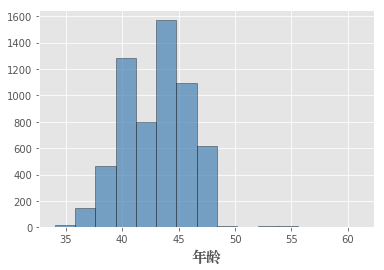

In [13]:
myfont = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/Songti.ttc')
plt.style.use('ggplot')
df['年龄'].hist( bins = 15, color = 'steelblue', edgecolor = 'k', alpha = 0.7)
plt.xlabel('年龄', FontProperties = myfont , fontsize = 15 )
plt.savefig('年龄分布图', dpi = 500, bbox_inches = 'tight')
plt.show()

### 3.2  教育背景分布

In [14]:
def label_educational(score):
    if score == 0 :
        return "大专以下"
    elif score == 10.5:
        return "大专"
    elif score == 15:
        return "本科"
    elif score == 26:
        return "硕士"
    elif score == 37:
        return "博士"
    else:
        return "其他"
df['label_学历水平'] = df['教育背景'].apply(label_educational)

pie = Pie("", width = 800, height = 600)
pie.add("学历分布", 
       df.groupby(['label_学历水平'])['姓名'].count().index,
       df.groupby(['label_学历水平'])['姓名'].count(),
       is_label_show = True,
        legend_orient = 'vertical',
        legend_pos = 'left')
pie.render("学历水平.html")


### 3.3  荣誉表彰

In [15]:
pie = Pie()
pie.add("荣誉表彰得分", 
       df.groupby(['荣誉表彰'])['姓名'].count().index,
       df.groupby(['荣誉表彰'])['姓名'].count(),
       is_label_show = True,
        legend_orient = 'vertical',
        legend_text_size = 20,
       label_text_size = 20)
pie.render('荣誉表彰比例.html')


### 3.4 创新创业

In [16]:
pie = Pie(width = 900, height = 800)
pie.add("创新创业", 
       df.groupby(['创新创业'])['姓名'].count().index,
       df.groupby(['创新创业'])['姓名'].count(),
       is_label_show = True,
        legend_orient = 'vertical',
       legend_pos = 'left',
        legend_text_size = 20,
       label_text_size = 20)
pie.render('创新创业比例.html')

### 3.5 性别


In [17]:
pie = Pie()
pie.add("性别", 
       df.groupby(['性别'])['姓名'].count().index,
       df.groupby(['性别'])['姓名'].count(),
       is_label_show = True,)
pie.render("性别分布.html")

### 3.6 原户籍

In [18]:
## 落户规模 -- map
def marry_province(province):
    if "黑龙江" in province or "内蒙古" in province:
        return province[:3]
    else:
        return province[:2]
df['原户籍省份'] = df['原户籍省份'].apply(marry_province)

map_ = Map("", width=1200, height=800)
province_dict = {}
for province in df['原户籍省份'].value_counts().keys():
    province_dict[province] = df['原户籍省份'].value_counts()[province]

attr, value = map_.cast(province_dict)
map_.add("原户籍分布", attr, value, visual_range = [0, 1000],
        maptype = 'china',
        symbol_size = 10, 
        is_visualmap = True)    

map_.render("各省落户规模_map.html")

In [19]:
## 落户规模 -- bar
bar = Bar(width=1200, height=600 )
attr = df['原户籍省份'].value_counts().keys()
value = df['原户籍省份'].value_counts()

bar.add("原户籍分布", attr, value, visual_range = [0, 1000],
        symbol_size = 10, 
        is_visualmap = True,
       xaxis_rotate = 50)    
bar.render("各省落户规模_bar.html")

In [20]:
city_df['省份'] = city_df['省份'].apply(marry_province)
features = ['省份', '省份人口']
city_df = city_df[features]
city_df = city_df.drop_duplicates() # 每个省份的人口

result = df.groupby(['原户籍省份'])['姓名'].count().to_frame() # 每个省份的落户北京的人口
result['省份'] = result.index

result = pd.merge(result, city_df, on = '省份', how = 'outer')
result = result.dropna()  ## 去重台湾/香港没落户的

result['落户北京概率'] = result['姓名'] / result['省份人口'] * 10

result = result.sort_values(by = ['落户北京概率'], ascending = False )

In [21]:
## 概率图 -- map
map_ = Map("", width=1200, height=800)
attr = result['省份']
value = result['落户北京概率']

map_.add("原户籍分布", attr, value, visual_range = [0, 2],
        maptype = 'china',
        symbol_size = 10, 
        is_visualmap = True)    

map_.render('各省落户北京概率_map.html')

In [22]:
## 概率图 -- bar
bar = Bar(width=1200, height=600 )
attr = result['省份']
value = result['落户北京概率']

bar.add("各省落户北京概率", attr, value,
        visual_range = [0, 2],
        symbol_size = 10, 
        is_visualmap = True,
       xaxis_rotate = 50)    

bar.render('各省落户北京概率_bar.html')

### 3.7 就业单位

In [23]:
attr = df['就业单位'].value_counts().keys()[:20]
value = df['就业单位'].value_counts()[:20]

bar = Bar(width=2500, height=600 )
bar.add("就业单位（前20名）", attr, value,
       is_convert = True )   

bar.render('就业单位前20名.html')

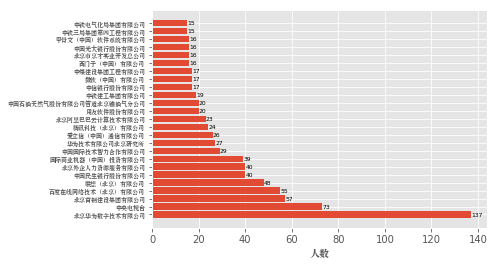

In [24]:
attr = df['就业单位'].value_counts().keys()[:25]
value = df['就业单位'].value_counts()[:25]
myfont = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/Songti.ttc')

plt.figure()
plt.barh(range(25), value, 
        align = 'center')

plt.xlabel('人数', FontProperties = myfont)
plt.yticks(range(25),attr , FontProperties = myfont , fontsize = 6)

for x,y in enumerate(value):
    plt.text( y + 0.1, x,'%s' %y,va='center', fontsize = 6 )
plt.savefig('就业单位', dpi = 800, bbox_inches = 'tight' )    
plt.show()

In [25]:
## 词云图
text = df['就业单位'].sum()
word_generator = jieba.cut(text)
stop_words = ['中国', "北京", "(", ")" , "集团", "有限" , "公司" , '（',  '）', "有限公司", '股份',
             '分公司','有限责任','北京市' , "北京" ]
words = []
for word in word_generator:
    if word not in stop_words:
        words.append(word)
    
word_dict = Counter(words)

count_list = sorted(word_dict.items(), key=lambda x:x[1],reverse=True)
keyword_list = [k[0] for k in count_list][:300]
value_list = [k[1] for k in count_list][:300]

wordcloud = WordCloud(width = 1200,height = 900)
wordcloud.add('',
              keyword_list,
              value_list,
              word_size_range=[20,100])
wordcloud.render('企业名次词云图.html')


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/5v/43zb1wt95qx954nbz6z9tx4m0000gn/T/jieba.cache
DEBUG:jieba:Dumping model to file cache /var/folders/5v/43zb1wt95qx954nbz6z9tx4m0000gn/T/jieba.cache
Loading model cost 1.156 seconds.
DEBUG:jieba:Loading model cost 1.156 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


In [26]:
## 企业类型
attr = ["国企/机关/央企/\n大学/研究所", "民营私企", "外资企业"]
value  = [0.2642, 0.4328,  0.303]
pie = Pie("企业类型", width = 1000 , height = 800)
pie.add("", 
       attr, value, 
       is_label_show = True,
        legend_text_size = 20,
       label_text_size = 20)
pie.render('企业类型.html')

In [27]:
## 500强企业占比
attr = ["500强", "非500强"]
value  = [0.72, 0.235]

pie = Pie("500强企业占比(剔除国企机关)", width = 800 , height = 600)
pie.add("", 
       attr, value, 
        radius = (40,75),
       is_label_show = True,
       legend_text_size = 20,
       label_text_size = 20)
pie.render('500强企业占比.html')

### 3.8 最终得分分布

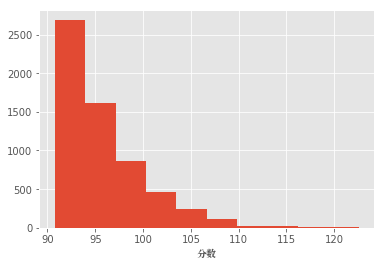

In [28]:
myfont = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/Songti.ttc')

df['总得分'].hist()
plt.xlabel('分数', FontProperties = myfont  )
plt.savefig('分数分布', bbox_inches = 'tight', dpi = 500)
plt.show()